In [1]:
import os
import numpy as np
from scipy.stats import pearsonr
import pandas as pd


# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [3]:
meta_activity_map_file = "../data/meta_activity_map.csv"
save_dir = "../data/figures/activity_map"
libraries = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

In [4]:
meta_df = pd.read_csv(meta_activity_map_file)

In [5]:
meta_df["variability"] = meta_df.loc[:, libraries].std(axis=1)
variable_df = meta_df.sort_values("variability", ascending=False).reset_index(drop=False)
variable_df = variable_df.loc[variable_df.variability>1.25]

# # merge overlapping locations
# merge_df_locations = merge_df.chrom_coord.str.split("_", expand=True)
# merge_df_locations.columns = ["chr", "start", "end"]
# merge_df_locations = merge_df_locations.astype({'start': 'int32', 'end': 'int32'})
# merge_df = merge_df.merge(merge_df_locations, left_index=True, right_index=True)
# merge_df = merge_df.sort_values(["chr", "start", "end"])

# dict_function = {"index": lambda x: list(x)[0], "start": min, "end": max}
# for lib in libraries[1:]:
#     dict_function[lib] = max # max activity value for each fragment
#     dict_function[f"{lib}_padj"] = min # min significance value for each fragment
# grouped_dfs = []
# for group, df in merge_df.groupby("chr"): # https://stackoverflow.com/questions/46732760/merge-rows-pandas-dataframe-based-on-condition
#     grouped_df = df.groupby(((df.start  - df.end.shift(1)) > 0).cumsum()).agg(dict_function)
#     grouped_df["chr"] = group
#     grouped_dfs.append(grouped_df)

# merged_df = pd.concat(grouped_dfs)

In [6]:
activity_df = variable_df.melt(id_vars=["index"], value_vars=libraries[1:], var_name="Libraries", value_name="activity")
diff_activity_df = variable_df.melt(id_vars=["index"], value_vars=[f"{l}_padj" for l in libraries[1:]], var_name="Libraries", value_name="diff_activity")
diff_activity_df["Libraries"] = diff_activity_df.Libraries.str.rstrip("_padj")
plot_df = activity_df.merge(diff_activity_df, left_on = ["index", "Libraries"], right_on=["index", "Libraries"])
plot_df["diff_activity_style"] = "not significant"
plot_df.loc[plot_df.diff_activity<0.05, "diff_activity_style"] = "significant"
plot_df = plot_df.set_index("index")

In [7]:
def plot_diff_activity_map(meta_df, plot_df, libraries, region_idx, region_dir, legend=True):
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    sns.lineplot(data=meta_df, x=meta_df.index, y="CC", ax=axes, linewidth=3.5, alpha=0.75, color="#1e61a5")

    plot_df = plot_df.loc[plot_df.Libraries.isin(libraries)]
    
    sns.scatterplot(    
        data=plot_df, x=plot_df.index, y="activity", ax=axes, 
        hue="Libraries", hue_order=libraries,
        palette=["red", "grey", "navy", "orange", "tan", "black"],
        style="diff_activity_style", style_order=["not significant", "significant"], markers={"not significant": ".", "significant": "*"},
        size="diff_activity_style", sizes={"not significant": 10, "significant": 100}, alpha=1,
        legend=legend, rasterized=True)

    if region_idx:
        for ridx,rdir in zip(region_idx, region_dir):
            loc = meta_df.loc[ridx].chrom_coord
            chrm, start, end = loc.split("_")
            act = meta_df.loc[ridx][libraries].max() if rdir=="high" else meta_df.loc[ridx][libraries].min()
            axes.annotate(f"{chrm}:{start}-{end}", xy=(ridx, act), xytext=(ridx, 6.5), arrowprops=dict(arrowstyle="->"), fontsize=10)
            # axes.text(ridx, act + np.sign(act)*0.25, f"{chrm}:{start}-{end}", fontsize=12, rotation=90, ha="center")

    # no x tick labels
    axes.set_xlabel("")
    axes.set_xticks([])
    axes.set_xticklabels([])
    # y label ticks needed
    axes.yaxis.set_tick_params(width=2, length=5, which="major")
    axes.yaxis.get_label().set_visible(False)
    axes.yaxis.set_major_locator(MultipleLocator(2))
    # draw a line at 
    axes.axhline(0, color ='black', lw = 2, alpha = 1)
    # remove spines
    axes.spines[["right", "top", "bottom"]].set_visible(False)
    if legend:
        axes.legend(markerscale=1.5, frameon=False, ncol=3, loc="lower right")
    return fig, axes

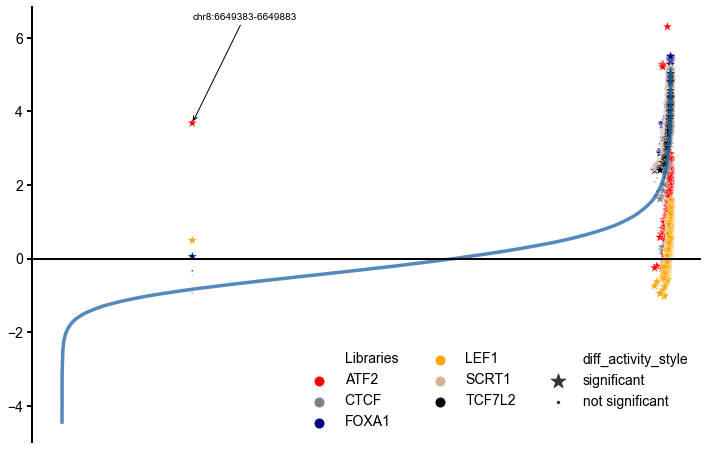

In [8]:
fig, _ = plot_diff_activity_map(meta_df, plot_df, libraries[1:-1], region_idx=[54278], region_dir=["high"])
save_file = f"../data/figures/activity_map/diff_activity.pdf"
save_pdf(save_file, fig)

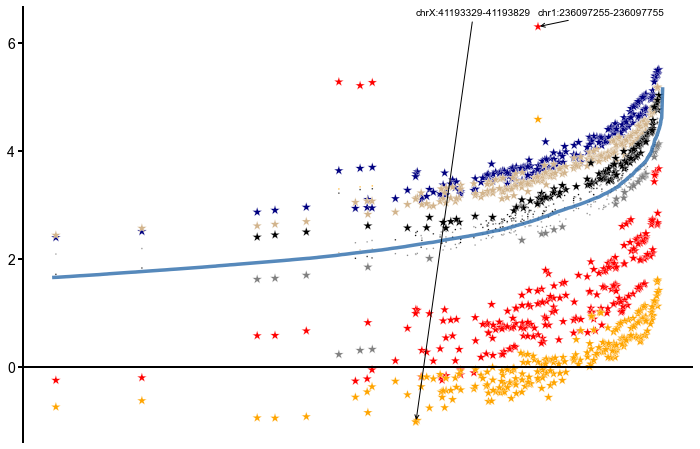

In [9]:
fig, _ = plot_diff_activity_map(meta_df.iloc[246900:], plot_df.loc[(plot_df.index>246900)], libraries[1:-1], region_idx=[252253, 250903], region_dir=["high", "low"], legend=False)
save_file = f"../data/figures/activity_map/diff_activity_zoomed.pdf"
save_pdf(save_file, fig)